In [1]:
import os
import glob
from copy import deepcopy
from utils.params import dict_update
from dataset.utils.homographic_augmentation import homographic_aug_pipline
from dataset.utils.photometric_augmentation import PhotoAugmentor
from utils.keypoint_op import compute_keypoint_map
from dataset.utils.photometric_augmentation import *
from torchvision import transforms
from torch.utils.data import DataLoader

In [5]:
class SelfDataset(torch.utils.data.Dataset):

    def __init__(self, config, is_train, device='cpu'):

        super(SelfDataset, self).__init__()
        self.device = device
        self.is_train = is_train
        self.resize = tuple(config['resize'])
        self.photo_augmentor = PhotoAugmentor(config['augmentation']['photometric'])
        self.config = config
        if self.is_train:
            self.samples = self._init_data(config['image_train_path'], config['label_train_path'], config['pairs_train_path'])
        else:
            self.samples = self._init_data(config['image_test_path'], config['label_test_path'], config['pairs_test_path'])


    def _init_data(self, image_path, label_path=None, pair_path=None):
        ##
        if not isinstance(image_path,list):
            image_paths, label_paths, pair_paths = [image_path,], [label_path,], [pair_path,]
        else:
            image_paths, label_paths, pair_paths = image_path, label_path, pair_path

        image_types = ['jpg','jpeg','bmp','png']
        samples = []
        for im_path, lb_path, pair_path in zip(image_paths, label_paths, pair_paths):
            pairs = np.load(os.path.join(pair_path, 'pairs.npy'), allow_pickle=True)
            pairs = pairs.item()
            templist = ['1377155868.png']
            for key in templist:
                filename = key.split(".")[0]
                temp_im = os.path.join(im_path, key)
                if lb_path is not None:
                    temp_lb = os.path.join(lb_path, filename+'.npy')
                else:
                    temp_lb = None
                for i in range(len(pairs[key]['pairs'])):
                    pair = pairs[key]['pairs'][i]
                    filename = pair.split(".")[0]
                    covisibility = pairs[key]['covisibility'][i]
                    index = pairs[key]['index'][i]
                    temp_im1 = os.path.join(im_path, pair)
                    if lb_path is not None:
                        temp_lb1 = os.path.join(lb_path, filename+'.npy')
                    else:
                        temp_lb1 = None
                    samples.append({'image':temp_im, 'label':temp_lb, 'image1':temp_im1, 'label1': temp_lb1, 'index': index, 'covisibility': covisibility})
        return samples

    def __len__(self):
        return len(self.samples)


    def __getitem__(self, idx):
        '''load raw data'''
        
        data_path = self.samples[idx]
        
         # load images
        print(data_path['image'])
        print(data_path['image1'])
        img = cv2.imread(data_path['image'], 0)#Gray image
        img = cv2.resize(img, self.resize[::-1])
        img_tensor = torch.as_tensor(img.copy(), dtype=torch.float, device=self.device)
        img1 = cv2.imread(data_path['image1'], 0)#Gray image
        img1 = cv2.resize(img1, self.resize[::-1])
        img_tensor1 = torch.as_tensor(img1.copy(), dtype=torch.float, device=self.device)

        pts = None if data_path['label'] is None else np.load(data_path['label'])[:, [1,0,2]]
        pts1 = None if data_path['label1'] is None else np.load(data_path['label1'])[:, [1,0,2]]
        pts[:, 0] = (pts[:, 0]+0.5)/1280*self.resize[0]
        pts[:, 1] = (pts[:, 1]+0.5)/1920*self.resize[1]
        pts1[:, 0] = (pts1[:, 0]+0.5)/1280*self.resize[0]
        pts1[:, 1] = (pts1[:, 1]+0.5)/1920*self.resize[1]
        
        kpts_tensor = None if pts is None else torch.as_tensor(pts, device=self.device)
        kpts_tensor1 = None if pts1 is None else torch.as_tensor(pts1, device=self.device)
        
        # compute maps
        kpts_map = None if pts is None else compute_keypoint_map(kpts_tensor, img.shape, device=self.device, id_included=True)
        kpts_map1 = None if pts1 is None else compute_keypoint_map(kpts_tensor1, img1.shape, device=self.device, id_included=True)
        valid_mask = torch.ones(img.shape, device=self.device)
        valid_mask1 = torch.ones(img1.shape, device=self.device)
        pairs = torch.as_tensor(np.array(data_path['covisibility']).astype(np.float32), device=self.device)
        index = torch.as_tensor(np.array(data_path['index']).astype(np.float32), device=self.device)


        data = {    'image':{'raw':{'img': img_tensor,
                                    'kpts': kpts_tensor,
                                    'kpts_map':kpts_map,
                                    'mask': valid_mask},
                            'warp':{'img': None,
                                    'kpts': None,
                                    'kpts_map':None,
                                    'mask': None},
                            'homo': torch.eye(3,device=self.device)},
                    'image1':{'raw':{'img': img_tensor1,
                                    'kpts': kpts_tensor1,
                                    'kpts_map':kpts_map1,
                                    'mask': valid_mask1},
                            'warp':{'img': None,
                                    'kpts': None,
                                    'kpts_map':None,
                                    'mask': None},
                            'homo': torch.eye(3,device=self.device)}, 
                    'index': index,
                    'pairs': pairs      
                }
        
        data['image']['warp'] = deepcopy(data['image']['raw'])
        data['image1']['warp'] = deepcopy(data['image1']['raw'])
        
        if self.is_train:
            photo_enable = self.config['augmentation']['photometric']['train_enable']
            homo_enable = self.config['augmentation']['homographic']['train_enable']
        else:
            photo_enable = self.config['augmentation']['photometric']['test_enable']
            homo_enable = self.config['augmentation']['homographic']['test_enable']

        if homo_enable and data['image']['raw']['kpts'] is not None and data['image1']['raw']['kpts'] is not None:#homographic augmentation
            data_homo = homographic_aug_pipline(data['image']['warp']['img'],
                                                data['image']['warp']['kpts'],
                                                self.config['augmentation']['homographic'],
                                                device=self.device, id_included=True)
            data_homo1 = homographic_aug_pipline(data['image1']['warp']['img'],
                                                data['image1']['warp']['kpts'],
                                                self.config['augmentation']['homographic'],
                                                device=self.device, id_included=True)
            data['image'].update(data_homo)
            data['image1'].update(data_homo1)
            
        if photo_enable:
            photo_img = data['image']['warp']['img'].cpu().numpy().round().astype(np.uint8)
            photo_img = self.photo_augmentor(photo_img)
            data['image']['warp']['img'] = torch.as_tensor(photo_img, dtype=torch.float,device=self.device)
            photo_img1 = data['image1']['warp']['img'].cpu().numpy().round().astype(np.uint8)
            photo_img1 = self.photo_augmentor(photo_img1)
            data['image1']['warp']['img'] = torch.as_tensor(photo_img1, dtype=torch.float,device=self.device)
      
        # normalize
        data['image']['raw']['img'] = data['image']['raw']['img']/255.
        data['image']['warp']['img'] = data['image']['warp']['img']/255.
        data['image1']['raw']['img'] = data['image1']['raw']['img']/255.
        data['image1']['warp']['img'] = data['image1']['warp']['img']/255.
        
        return data
    

    def batch_collator(self, samples):
        """
        :param samples:a list, each element is a dict with keys
        like `img`, `img_name`, `kpts`, `kpts_map`,
        `valid_mask`, `homography`...
        img:H*W, kpts:N*2, kpts_map:HW, valid_mask:HW, homography:HW
        :return:
        """
        sub_data={  'raw':{ 'img':      [],
                            'kpts':     [],
                            'kpts_map': [],
                            'mask':     []},
                    'warp':{'img':      [],
                            'kpts':     [],
                            'kpts_map': [],
                            'mask':     []},
                    'homo':             []}
        batch = {'image':deepcopy(sub_data), 'image1':deepcopy(sub_data), 'index': [], 'pairs': []}
        for s in samples:
            batch['index'].append(s['index'])
            batch['pairs'].append(s['pairs'])
            batch['image']['raw']['img'].append(s['image']['raw']['img'].unsqueeze(dim=0))
            batch['image']['raw']['kpts'].append(s['image']['raw']['kpts'])
            batch['image']['raw']['kpts_map'].append(s['image']['raw']['kpts_map'])
            batch['image']['raw']['mask'].append(s['image']['raw']['mask'])
            batch['image']['warp']['img'].append(s['image']['warp']['img'].unsqueeze(dim=0))
            batch['image']['warp']['kpts'].append(s['image']['warp']['kpts'])
            batch['image']['warp']['kpts_map'].append(s['image']['warp']['kpts_map'])
            batch['image']['warp']['mask'].append(s['image']['warp']['mask'])
            batch['image']['homo'].append(s['image']['homo'])
            batch['image1']['raw']['img'].append(s['image1']['raw']['img'].unsqueeze(dim=0))
            batch['image1']['raw']['kpts'].append(s['image1']['raw']['kpts'])
            batch['image1']['raw']['kpts_map'].append(s['image1']['raw']['kpts_map'])
            batch['image1']['raw']['mask'].append(s['image1']['raw']['mask'])
            batch['image1']['warp']['img'].append(s['image1']['warp']['img'].unsqueeze(dim=0))
            batch['image1']['warp']['kpts'].append(s['image1']['warp']['kpts'])
            batch['image1']['warp']['kpts_map'].append(s['image1']['warp']['kpts_map'])
            batch['image1']['warp']['mask'].append(s['image1']['warp']['mask'])
            batch['image1']['homo'].append(s['image1']['homo'])
        batch['index'] = torch.stack(batch['index']) 
        batch['pairs'] = torch.stack(batch['pairs'])
        for k0 in ('image','image1'):
            batch[k0]['homo'] = torch.stack(batch[k0]['homo'])
            for k1 in ('raw','warp'):
                for k2 in sub_data['raw']:
                    batch[k0][k1][k2] = torch.stack(batch[k0][k1][k2])
        return batch

/Users/zhouchang/Desktop/SuperPoint-Pytorch-master/data/self/images/1377155868.png
/Users/zhouchang/Desktop/SuperPoint-Pytorch-master/data/self/images/507250611.png


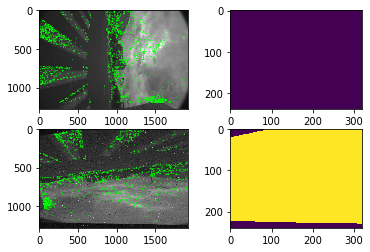

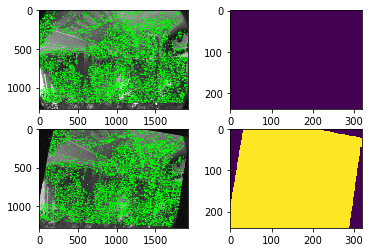

/Users/zhouchang/Desktop/SuperPoint-Pytorch-master/data/self/images/1377155868.png
/Users/zhouchang/Desktop/SuperPoint-Pytorch-master/data/self/images/373561410.png


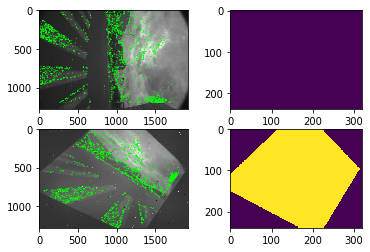

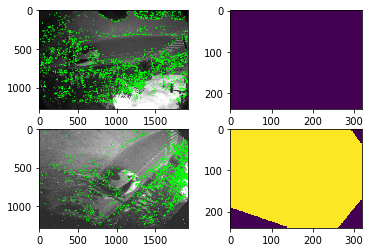

/Users/zhouchang/Desktop/SuperPoint-Pytorch-master/data/self/images/1377155868.png
/Users/zhouchang/Desktop/SuperPoint-Pytorch-master/data/self/images/89766047.png


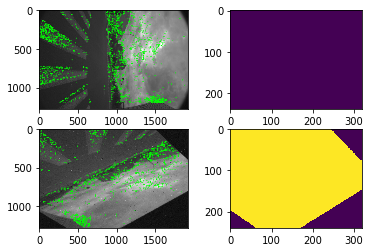

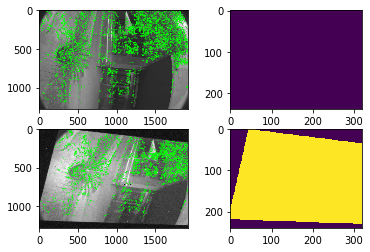

/Users/zhouchang/Desktop/SuperPoint-Pytorch-master/data/self/images/1377155868.png
/Users/zhouchang/Desktop/SuperPoint-Pytorch-master/data/self/images/1199353954.png


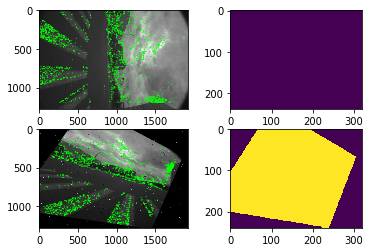

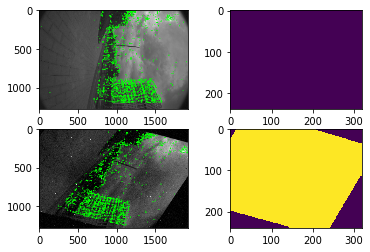

/Users/zhouchang/Desktop/SuperPoint-Pytorch-master/data/self/images/1377155868.png
/Users/zhouchang/Desktop/SuperPoint-Pytorch-master/data/self/images/192992172.png


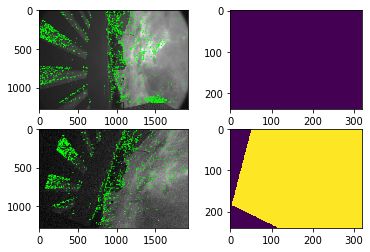

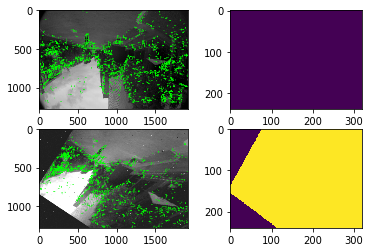

/Users/zhouchang/Desktop/SuperPoint-Pytorch-master/data/self/images/1377155868.png
/Users/zhouchang/Desktop/SuperPoint-Pytorch-master/data/self/images/1359855567.png
Done


In [6]:
if __name__=='__main__':
    import yaml
    import matplotlib.pyplot as plt
    from dataset.utils.photometric_augmentation import *
    with open('/Users/zhouchang/Desktop/SuperPoint-Pytorch-master/config/superpoint_train.yaml','r') as fin:
        config = yaml.safe_load(fin)

    selfdata = SelfDataset(config['data'],True)
    cdataloader = DataLoader(selfdata,collate_fn=selfdata.batch_collator,batch_size=1,shuffle=True)

    for i,d in enumerate(cdataloader):
        if i>=5:
            break
        img = (d['image']['raw']['img']*255).cpu().numpy().squeeze().astype(np.int).astype(np.uint8)
        img_warp = (d['image']['warp']['img']*255).cpu().numpy().squeeze().astype(np.int).astype(np.uint8)
        img = cv2.merge([img, img, img])
        img_warp = cv2.merge([img_warp, img_warp, img_warp])
        kpts = np.where(d['image']['raw']['kpts_map'].squeeze().cpu().numpy())
        kpts = np.vstack(kpts).T
        kpts = np.round(kpts).astype(np.int)
        for kp in kpts:
            cv2.circle(img, (kp[1], kp[0]), radius=1, color=(0,255,0))
            
            
        kpts = np.where(d['image']['warp']['kpts_map'].squeeze().cpu().numpy())
        kpts = np.vstack(kpts).T
        kpts = np.round(kpts).astype(np.int)
        for kp in kpts:
            cv2.circle(img_warp, (kp[1], kp[0]), radius=1, color=(0,255,0))

        mask = d['image']['raw']['mask'].cpu().numpy().squeeze().astype(np.int).astype(np.uint8)*255
        warp_mask = d['image']['warp']['mask'].cpu().numpy().squeeze().astype(np.int).astype(np.uint8)*255

        img = cv2.resize(img, (1920,1280))
        img_warp = cv2.resize(img_warp,(1920,1280))

        plt.subplot(2,2,1)
        plt.imshow(img)
        plt.subplot(2,2,2)
        plt.imshow(mask)
        plt.subplot(2,2,3)
        plt.imshow(img_warp)
        plt.subplot(2,2,4)
        plt.imshow(warp_mask)
        plt.show()
        
        img = (d['image1']['raw']['img']*255).cpu().numpy().squeeze().astype(np.int).astype(np.uint8)
        img_warp = (d['image1']['warp']['img']*255).cpu().numpy().squeeze().astype(np.int).astype(np.uint8)
        img = cv2.merge([img, img, img])
        img_warp = cv2.merge([img_warp, img_warp, img_warp])
        
        kpts = np.where(d['image1']['raw']['kpts_map'].squeeze().cpu().numpy())
        kpts = np.vstack(kpts).T
        kpts = np.round(kpts).astype(np.int)
        for kp in kpts:
            cv2.circle(img, (kp[1], kp[0]), radius=1, color=(0,255,0))
            
        kpts = np.where(d['image1']['warp']['kpts_map'].squeeze().cpu().numpy())
        kpts = np.vstack(kpts).T
        kpts = np.round(kpts).astype(np.int)
        for kp in kpts:
            cv2.circle(img_warp, (kp[1], kp[0]), radius=1, color=(0,255,0))

        mask = d['image1']['raw']['mask'].cpu().numpy().squeeze().astype(np.int).astype(np.uint8)*255
        warp_mask = d['image1']['warp']['mask'].cpu().numpy().squeeze().astype(np.int).astype(np.uint8)*255

        img = cv2.resize(img, (1920,1280))
        img_warp = cv2.resize(img_warp,(1920,1280))

        plt.subplot(2,2,1)
        plt.imshow(img)
        plt.subplot(2,2,2)
        plt.imshow(mask)
        plt.subplot(2,2,3)
        plt.imshow(img_warp)
        plt.subplot(2,2,4)
        plt.imshow(warp_mask)
        plt.show()
        
    print('Done')

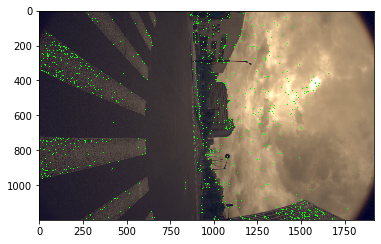

In [7]:
import os
import glob
from copy import deepcopy
from utils.params import dict_update
from dataset.utils.homographic_augmentation import homographic_aug_pipline
from dataset.utils.photometric_augmentation import PhotoAugmentor
from utils.keypoint_op import compute_keypoint_map
from dataset.utils.photometric_augmentation import *
from torchvision import transforms
from torch.utils.data import DataLoader

img = cv2.imread('/Users/zhouchang/Desktop/SuperPoint-Pytorch-master/data/self/images/1377155868.png').squeeze().astype(np.int).astype(np.uint8)
kpts = np.load('/Users/zhouchang/Desktop/SuperPoint-Pytorch-master/data/self/keypoints/1377155868.npy').astype(np.float32)


for kp in kpts:
    cv2.circle(img, (int(kp[0]+0.5), int(kp[1]+0.5)), radius=3, color=(0,255,0))
plt.imshow(img)
plt.show()